# Introduction
The aim of this project is...

# Import Dependencies

In [3]:
import requests as req
import pandas as pd
import numpy as np
import random
import math

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import ast
import pprint

from tqdm import tqdm

# Data Collection
The cells below will follow a series of steps to collect data about our users and Anime content.

## Kitsu API

Kitsu is a modern anime discovery platform that helps you track the anime you're watching, discover new anime and socialize with other fans.

Within the Kitsu API __https://kitsu.docs.apiary.io/__ -- it contains data pertaining to users and the anime they have watched, rated, liked, commented, and overall have interacted with.

In the next few cells we will aim to pull a initial sample of ~500 users and their interaction data.

In total, there are 1,182,501 users and through the API, we are able to traverse through 20 results at a time. If we traverse through all 1.1M users only 20 at a time, we will need to make 59,125 iterations. 

For MVP purposes, we will pull a sample of 5,000 random users only needing 250 iterations.

To randomly select the 5,000 users knowing we can pull 20 from a page at a time -- we will use the following code to select for those users.

In [4]:
num_users = 1182501
sample_n = 5000
users_per_page = 20
pages_n = int(sample_n / users_per_page)

# Increment the pages
pages_array = np.arange(0,num_users,pages_n)

# Shuffle the array of pages
np.random.shuffle(pages_array)

# Get the first pages_n from pages_array
pages_to_query = pages_array[:pages_n]

print(f'The pages to iterate through: {pages_n} \nThe number of users data to collect: {pages_n*users_per_page}')

The pages to iterate through: 250 
The number of users data to collect: 5000


In [5]:
# Create users dict to collect data
users_dict = {'id':[],
              'name':[],
              'location':[],
              'createdAt':[],
              'lifeSpentOnAnime':[],
              'followersCount':[],
              'followingCount':[],
              'birthday':[],
              'commentsCount':[],
              'favoritesCount':[],
              'likesGivenCount':[],
              'reviewsCount':[],
              'likesReceivedCount':[],
              'postsCount':[],
              'ratingsCount':[],
              'likesReceivedCount':[],
              'proTier':[],
              'relationships':[]}

## Iterate through pages of the Kitsu API to retrieve user data

In [6]:
# Create list of keys to later iterate through 
data_extract = list(users_dict.keys())
data_extract.remove('id')
data_extract.remove('relationships')

# Set up link to iterate through
for page_num in tqdm(pages_to_query):
# for page_num in [20]:
    
    # Set up link to retrieve response from
    kitsu_link = f"https://kitsu.io/api/edge/users?page%5Blimit%5D=20&page%5Boffset%5D={page_num}"

    # Retrieve response
    response = req.get(kitsu_link)
    data = response.json()

    # Iterate through 'data' list in json API response
    for user in data['data']:
        
        # Retrieve desired data points
        attr = user['attributes']
        user_id = user['id']
        rel = user['relationships']
        
        users_dict['id'].append(user_id)
        users_dict['relationships'].append(rel)
        
        # Iterate through users_dict keys for particular data points of interest
        for key in data_extract:
            users_dict[key].append(attr.get(key, np.nan))

In [99]:
# convert users_dict to a dataframe
# animeUsers_df = pd.DataFrame(users_dict)

# Save to csv
# animeUsers_df.to_csv('animeUsers.csv',index=False)

In [7]:
animeUsers_df = pd.read_csv('animeUsers.csv')

In [8]:
# Peek at data
animeUsers_df.head()

,id,name,location,createdAt,lifeSpentOnAnime,followersCount,followingCount,birthday,commentsCount,favoritesCount,likesGivenCount,reviewsCount,likesReceivedCount,postsCount,ratingsCount,proTier,relationships
0,717575,ybicona,Baltimore,2020-04-29T16:36:29.021Z,0,0,0,NaN,0,0,0,0,0,0,0,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
1,717576,skgsudhirkumar,NaN,2020-04-29T16:36:35.763Z,0,0,0,NaN,0,0,0,0,0,0,0,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2,717577,βαγγέλης_μαχαίρας,NaN,2020-04-29T16:37:05.758Z,0,0,0,NaN,0,0,0,0,0,0,12,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
3,717578,Mame,NaN,2020-04-29T16:37:44.164Z,0,0,0,NaN,0,0,0,0,0,0,5,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
4,717579,ryan_maulana,NaN,2020-04-29T16:38:07.323Z,0,0,0,NaN,0,0,0,0,0,0,0,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...


In [9]:
animeUsers_df.sort_values('favoritesCount',ascending=False).head(10)

,id,name,location,createdAt,lifeSpentOnAnime,followersCount,followingCount,birthday,commentsCount,favoritesCount,likesGivenCount,reviewsCount,likesReceivedCount,postsCount,ratingsCount,proTier,relationships
979,85539,maria12021,Norway,2015-04-06T00:55:29.333Z,74217,4,2,2001-04-18,0,209,0,0,0,0,605,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2754,143115,Liv_Martin_Strong,UK,2017-01-16T01:03:19.919Z,0,36,28,1991-08-14,44,139,26,27,30,33,280,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
3747,121938,70a573r,The Government,2016-03-20T23:46:32.451Z,20854,6,2,2001-09-11,2,86,4,1,7,3,5,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
3971,70211,LadyGira,Pirate Ship,2014-12-09T04:44:12.856Z,451853,5,10,NaN,0,82,10,0,1,0,1040,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2523,86869,nick_gooeygrass,NaN,2015-04-15T23:18:46.962Z,73828,1,1,NaN,0,55,0,0,0,0,96,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2149,78730,Iago,South,2015-02-07T13:48:55.698Z,137029,69,61,NaN,6,51,986,0,-9,3,655,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2487,561112,kevintombs20,NaN,2019-08-13T18:19:22.094Z,0,0,0,NaN,0,46,0,0,0,0,71,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
4833,100364,Wolfwood93,Colorado,2015-08-08T17:34:30.626Z,96306,15,6,1993-09-13,2,44,14,0,-2,-1,178,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
119,278590,BarretKun,"São Bernardo do Campo, SP, Brazil",2018-05-29T16:05:06.030Z,0,1,1,1999-06-24,0,41,0,0,0,0,172,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
1970,582074,Legorion,"Latvia,Riga",2019-09-22T15:42:08.578Z,0,4,5,1986-09-22,1,39,3,0,0,0,37,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...


commentsCount        2178
favoritesCount       4178
likesGivenCount      5689
reviewsCount          100
postsCount            920
ratingsCount       135568
dtype: int64



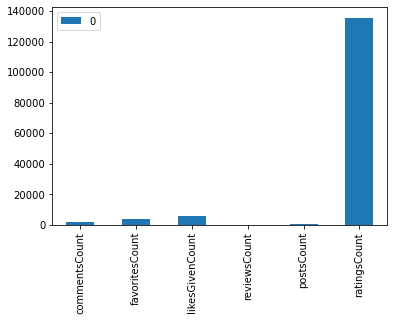

In [10]:
# Examine distribution of interaction types among users
interaction_list = ['commentsCount',
                    'favoritesCount', 
                    'likesGivenCount', 
                    'reviewsCount',
                    'postsCount', 
                    'ratingsCount']

print(animeUsers_df[interaction_list].sum())
print()

pd.DataFrame(animeUsers_df[interaction_list].sum()).plot(kind='bar');

- favorites
- reviews
    - https://kitsu.io/api/edge/users/22/reviews; reviews id; https://kitsu.io/api/edge/reviews/review id/media

In [11]:
# Peek at few examples of relationships column
jt = ast.literal_eval(animeUsers_df['relationships'][1])
jt2 = ast.literal_eval(animeUsers_df['relationships'][4])

In [12]:
def get_kitsu_response(link):
    """
    Returns a pretty printed response from JSON object
    
    Parameters
    ----------
    link : str
        The URL to query from Kitsu API

    Returns
    -------
    pretty printed view of json response
    
    """
    kitsu_response = req.get(link)
    kitsu_data = kitsu_response.json()
    return kitsu_data

In [13]:
# Check kitsu response
get_kitsu_response( jt['favorites']['links']['related'] )

{'data': [],
 'meta': {'count': 0},
 'links': {'first': 'https://kitsu.io/api/edge/users/717576/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0',
  'last': 'https://kitsu.io/api/edge/users/717576/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0'}}

In [14]:
# Check kitsu response
get_kitsu_response( jt2['favorites']['links']['related'] )

{'data': [],
 'meta': {'count': 0},
 'links': {'first': 'https://kitsu.io/api/edge/users/717579/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0',
  'last': 'https://kitsu.io/api/edge/users/717579/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0'}}

## Retrieve Favorite Anime per User

In [15]:
def get_user_favorites(user_id):
    """
    Returns a list of a user's favorite anime
    
    Parameters
    ----------
    user_id : int
        user_id
    Returns
    -------
    Dictionary of the user's favorited anime
    
    """
    print(f'Retrieving favorites data for user {user_id}')
    kitsu_link = f'https://kitsu.io/api/edge/favorites/?filter[userId]={user_id}&[itemType]=Media'
    kitsu_response = req.get(kitsu_link)
    kitsu_data = kitsu_response.json()

    # Store favorites dictionary
    fav_dict = {
        'user_id': None,
        'anime_id': [],
        'canonicalTitle': [],
        'synopsis': [],
        'description': []
    }

    # Check for number of favorites -- if more than 10; paginate through all favorites else retrieve favorites on page
    favorites_count = kitsu_data['meta']['count']

    pages = math.floor((favorites_count / 10) + 1)
    page_nums = []
    count = 0
    # Create list of pages to paginate through
    for num in range(pages):
        page_nums.append(num * 10)

    # Retrieve data from each page
    for page in tqdm(page_nums):
        link = f'https://kitsu.io/api/edge/favorites?filter%5BuserId%5D={user_id}&page%5Blimit%5D=10&page%5Boffset%5D={page}'
        fav_page = get_kitsu_response(link)
        for fav in fav_page['data']:

            # Get link to retrieve anime data
            item = fav['relationships']['item']['links']['related']
            anime_response = get_kitsu_response(item)

            # Check that the user's marked favorite is an anime
            if anime_response['data']['type'] == 'anime':

                title = anime_response['data']['attributes'].get(
                    'canonicalTitle', np.nan)
                anime_id = anime_response['data'].get('id', np.nan)
                synopsis = anime_response['data']['attributes'].get(
                    'synopsis', np.nan)
                desc = anime_response['data']['attributes'].get(
                    'description', np.nan)

                fav_dict['anime_id'].append(anime_id)
                fav_dict['canonicalTitle'].append(title)
                fav_dict['synopsis'].append(synopsis)
                fav_dict['description'].append(desc)
                count += 1

            # If the marked favorite is not an anime --> skip
            else:
                continue

    # Create a list of the users_id to map every item to the user
    user_id_list = [user_id] * count
    fav_dict['user_id'] = user_id_list

    return fav_dict

## Retrieve Library Entries per User

In [16]:
def get_user_library_entries(user_id):
    """
    Returns a list of a user's library entries. 
    The output of this function will detail anime the user has watched, planned to watch, or stopped watching.
    
    Parameters
    ----------
    user_id : int
        user_id
    Returns
    -------
    Dictionary of the anime a user has interacted with.
    
    """
    print(f'Retrieving library entry data for user {user_id}')
    kitsu_link = f'https://kitsu.io/api/edge/library-entries/?filter[userId]={user_id}&[kind]=anime'
    kitsu_response = req.get(kitsu_link)
    kitsu_data = kitsu_response.json()

    # Store favorites dictionary
    lib_entry_dict = {
        'user_id': None,
        'anime_id': [],
        'status': [],
        'progress': [],
        'progressedAt': [],
        'startedAt': [],
        'finishedAt': [],
        'canonicalTitle': [],
        'synopsis': [],
        'description': []
    }

    # Check for number of favorites -- if more than 10; paginate through all favorites else retrieve favorites on page
    entries_count = kitsu_data['meta']['count']

    pages = math.floor((entries_count / 10) + 1)
    page_nums = []
    count = 0
    # Create list of pages to paginate through
    for num in range(pages):
        page_nums.append(num * 10)

    # Retrieve data from each page
    for page in tqdm(page_nums[:5]):
        link = f'https://kitsu.io/api/edge/library-entries?filter%5BuserId%5D={user_id}&page%5Blimit%5D=10&page%5Boffset%5D={page}'
        le_page = get_kitsu_response(link)
        for le in le_page['data']:

            # Retrieve watch status data
            attr = le['attributes']
            status = attr['status']
            progress = attr['progress']
            progressedAt = attr['progressedAt']
            startedAt = attr['startedAt']
            finishedAt = attr['finishedAt']

            # Get link to retrieve anime data
            item = le['relationships']['anime']['links']['related']
            anime_response = get_kitsu_response(item)
            try:
                title = anime_response['data']['attributes'].get(
                    'canonicalTitle', np.nan)
                anime_id = anime_response['data'].get('id', np.nan)
                synopsis = anime_response['data']['attributes'].get(
                    'synopsis', np.nan)
                desc = anime_response['data']['attributes'].get(
                    'description', np.nan)

                lib_entry_dict['status'].append(status)
                lib_entry_dict['progress'].append(progress)
                lib_entry_dict['progressedAt'].append(progressedAt)
                lib_entry_dict['startedAt'].append(progressedAt)
                lib_entry_dict['finishedAt'].append(finishedAt)
                lib_entry_dict['anime_id'].append(anime_id)
                lib_entry_dict['canonicalTitle'].append(title)
                lib_entry_dict['synopsis'].append(synopsis)
                lib_entry_dict['description'].append(desc)
                count += 1
            except TypeError:
                continue

    # Create a list of the users_id to map every item to the user
    user_id_list = [user_id] * count
    lib_entry_dict['user_id'] = user_id_list

    return lib_entry_dict

# Run retrieval functions for a sample of users

In [17]:
# Select random list of users to retrive their interaction data
user_sample_list = [85539, 143115, 121938, 70211, 86869]

In [18]:
# Retrieve sample of favorites data per user
users_favs_df = pd.DataFrame()

for user in user_sample_list:
    df = pd.DataFrame(get_user_favorites(user))
    users_favs_df = users_favs_df.append(df)

Retrieving favorites data for user 85539


  0%|          | 0/14 [00:00<?, ?it/s]

Retrieving favorites data for user 143115


  0%|          | 0/9 [00:00<?, ?it/s]

Retrieving favorites data for user 121938


  0%|          | 0/9 [00:00<?, ?it/s]

Retrieving favorites data for user 70211


  0%|          | 0/6 [00:00<?, ?it/s]

Retrieving favorites data for user 86869


100%|██████████| 6/6 [00:11<00:00,  2.00s/it]


In [19]:
# Save anime favorites data per user
users_favs_df.to_csv('animeFavorites_data.csv',index=False)

# users_favs_df = pd.read_csv('animeFavorites_data.csv')

In [20]:
# Retrieve sample of library entries data per user
users_le_df = pd.DataFrame()

for user in user_sample_list:
    df = pd.DataFrame(get_user_library_entries(user))
    users_le_df = users_le_df.append(df)

Retrieving library entry data for user 85539


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


Retrieving library entry data for user 143115


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Retrieving library entry data for user 121938


100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


Retrieving library entry data for user 70211


  0%|          | 0/5 [00:00<?, ?it/s]

Retrieving library entry data for user 86869


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


In [21]:
# Save anime library entries data per user
users_le_df.to_csv('animeWatchStatus_data.csv',index=False)

# users_le_df = pd.read_csv('animeWatchStatus_data.csv')

In [22]:
# Peek at users library entries data
users_le_df.head()

,user_id,anime_id,status,progress,progressedAt,startedAt,finishedAt,canonicalTitle,synopsis,description
0,85539,176,completed,1,2016-04-05T21:53:57.987Z,2016-04-05T21:53:57.987Z,2016-04-05T00:00:00.000Z,Spirited Away,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Stubborn, spoiled, and naïve, 10-year-old Chih..."
1,85539,6711,completed,1,2015-11-07T21:02:56.128Z,2015-11-07T21:02:56.128Z,2015-11-07T00:00:00.000Z,Wolf Children,"Hana, a hard-working college student, falls in...","Hana, a hard-working college student, falls in..."
2,85539,142,completed,1,2016-04-05T21:54:13.337Z,2016-04-05T21:54:13.337Z,2016-04-05T00:00:00.000Z,Princess Mononoke,When an Emishi village is attacked by a fierce...,When an Emishi village is attacked by a fierce...
3,85539,8403,completed,22,2015-04-06T00:57:29.294Z,2015-04-06T00:57:29.294Z,2015-04-06T00:00:00.000Z,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...
4,85539,8147,completed,24,2017-04-14T04:09:37.510Z,2017-04-14T04:09:37.510Z,2017-04-14T00:00:00.000Z,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien..."


# Data Processing to set up Recommender Model
In this section we are going to process the data from user favorites and library entries so we can create the user and anime vectors to feed into our implicit alternating least squares (ALS) recommender model. We will follow the steps below.
1. Combine the data from user favorites and user library entries.
2. Afterwards, we create an arbitrary "eventStrength" based on the status column to indicate the "level of interaction" a user has with a particular anime.
3. Create sparse ratings matrix and fit to implicit ALS model.

In [23]:
# Create status column to align and later combine with users_le_df
# 'favorite' will be used as an event type
users_favs_df['status'] = 'favorite'

In [24]:
# Peek at data
users_favs_df.head()

,user_id,anime_id,canonicalTitle,synopsis,description,status
0,85539,8403,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...,favorite
1,85539,8147,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien...",favorite
2,85539,6836,Tsuritama,Yuki Sanada is a socially awkward young man wh...,Yuki Sanada is a socially awkward young man wh...,favorite
3,85539,8333,Gugure! Kokkuri-san,"Kohina Ichimatsu, the self-proclaimed doll, ca...","Kohina Ichimatsu, the self-proclaimed doll, ca...",favorite
4,85539,5981,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,Jinta Yadomi is peacefully living as a recluse...,Jinta Yadomi is peacefully living as a recluse...,favorite


In [25]:
# Compare shapes of favs and library entries dataframes
print(users_favs_df.shape)
print(users_le_df.shape)

(306, 6)
(239, 10)


Between the user favorites and user library entries dataframe -- there is a difference in the number of columns. In this case we we will need to align and select our columns for further analysis.  

In [26]:
# Peek at select columns to keep in combined dataframe
list(users_favs_df.columns)

['user_id', 'anime_id', 'canonicalTitle', 'synopsis', 'description', 'status']

In [27]:
# Set columns between both dataframes to be equal for combining
col_list = list(users_favs_df.columns)

users_le_df_append = users_le_df.copy()

# Filter library entries df to match columns of favorites df
users_le_df_append = users_le_df_append[col_list]

# Combine library entries and favorites df
user_interaction_df = users_le_df_append.append(users_favs_df, ignore_index=True)

# Peek at data
user_interaction_df.head()

,user_id,anime_id,canonicalTitle,synopsis,description,status
0,85539,176,Spirited Away,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Stubborn, spoiled, and naïve, 10-year-old Chih...",completed
1,85539,6711,Wolf Children,"Hana, a hard-working college student, falls in...","Hana, a hard-working college student, falls in...",completed
2,85539,142,Princess Mononoke,When an Emishi village is attacked by a fierce...,When an Emishi village is attacked by a fierce...,completed
3,85539,8403,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...,completed
4,85539,8147,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien...",completed


Below we will assign an arbitrary event strength for the type of interactions users have had with certain types of anime. 

In [28]:
# Set up event strength dict to assign arbitrary strength score towards interaction types
event_strength = {
    'completed':6.0,
    'favorite':5.0,
    'current':4.0,
    'planned':3.0,
    'on_hold':2.0,
    'dropped':1.0
}

In [29]:
# Map event strength scores according to status set in user_interaction_df
user_interaction_df['eventStrength'] = user_interaction_df['status'].apply(lambda x: event_strength[x])

In [30]:
# Peek at data
user_interaction_df.head()

,user_id,anime_id,canonicalTitle,synopsis,description,status,eventStrength
0,85539,176,Spirited Away,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Stubborn, spoiled, and naïve, 10-year-old Chih...",completed,6.0
1,85539,6711,Wolf Children,"Hana, a hard-working college student, falls in...","Hana, a hard-working college student, falls in...",completed,6.0
2,85539,142,Princess Mononoke,When an Emishi village is attacked by a fierce...,When an Emishi village is attacked by a fierce...,completed,6.0
3,85539,8403,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...,completed,6.0
4,85539,8147,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien...",completed,6.0


In [31]:
# Group event strength per user and anime
grouped_df = user_interaction_df.groupby(['user_id', 'anime_id', 'canonicalTitle'])['eventStrength'].sum().reset_index()
grouped_df.sample(10)

,user_id,anime_id,canonicalTitle,eventStrength
445,143115,395,Howl's Moving Castle,11.0
374,121938,11467,New Game!,5.0
175,85539,13717,Ito Junji: Collection,5.0
271,85539,8638,Yuuki Yuuna wa Yuusha de Aru,5.0
437,143115,21,Neon Genesis Evangelion,6.0
370,121938,10941,Kono Subarashii Sekai ni Shukufuku wo!,6.0
191,85539,4474,Kämpfer,6.0
181,85539,2369,Sayonara Zetsubou Sensei,5.0
332,86869,7821,Nisekoi,5.0
284,86869,10085,"Gate: Jieitai Kanochi nite, Kaku Tatakaeri",6.0


With an aggregated eventStrength -- we aim to use this metric to represent a "confidence" measure in how strong the level of interaction was for a user and anime.

# Fit Alternating Least Squares Model

In [33]:
grouped_df['canonicalTitle'] = grouped_df['canonicalTitle'].astype("category")
grouped_df['user_id'] = grouped_df['user_id'].astype("category")
grouped_df['anime_id'] = grouped_df['anime_id'].astype("category")
grouped_df['person_id'] = grouped_df['user_id'].cat.codes
grouped_df['content_id'] = grouped_df['anime_id'].cat.codes

# Create sparse ratings matrix of users and anime
sparse_content_mat = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['content_id'], grouped_df['person_id'])))
sparse_person_mat = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['person_id'], grouped_df['content_id'])))

In [34]:
# Create lookup table that we tracks and reference id to title
anime_lookup = grouped_df[['content_id', 'canonicalTitle']].drop_duplicates()

In [35]:
# Peek at lookup table
anime_lookup.head()

,content_id,canonicalTitle
0,0,Cowboy Bebop
1,9,Fate/stay night: Unlimited Blade Works 2nd Season
2,14,Fushigi Yuugi
3,19,Slayers Try
4,25,Gensoumaden Saiyuuki


In [36]:
# Check out matrix object
sparse_content_mat

<385x5 sparse matrix of type '<class 'numpy.float64'>'
	with 470 stored elements in Compressed Sparse Row format>

In [38]:
# Check out matrix object
sparse_person_mat

<5x385 sparse matrix of type '<class 'numpy.float64'>'
	with 470 stored elements in Compressed Sparse Row format>

In [39]:
# Create ALS model and fit to sparse ratings matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (sparse_content_mat * alpha).astype('double')
model.fit(data)

In [40]:
# Calculate the matrix sparsity 
matrix_size = sparse_content_mat.shape[0]*sparse_content_mat.shape[1] # Number of possible interactions in the matrix
num_interact = len(sparse_content_mat.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_interact/matrix_size))
sparsity

75.58441558441558

According to the computed value above -- 75.6% of the interaction matrix is sparse. 

In [41]:
# Peek at random 10 rows
grouped_df.sample(10)

,user_id,anime_id,canonicalTitle,eventStrength,person_id,content_id
82,70211,7370,Nagi no Asukara,5.0,0,267
427,143115,11999,Yuri!!! on Ice,6.0,4,60
314,86869,6590,Accel World,6.0,2,221
171,85539,13465,Blend S,5.0,1,79
311,86869,6508,Ano Natsu de Matteru,6.0,2,217
305,86869,5583,IS: Infinite Stratos,11.0,2,187
167,85539,13259,Aho Girl,5.0,1,75
164,85539,13234,Tsuki ga Kirei,5.0,1,72
352,86869,8630,Madan no Ou to Vanadis,11.0,2,352
8,70211,1226,Taiho Shichau zo (TV),5.0,0,65


# Set up initial recommendation model using interaction data

In [42]:
# Importing useful recommendation functions from .py file
# Credit to https://github.com/jmsteinw
from implicit_rec_functions import *

In [44]:
product_train, product_test, product_users_altered = make_train(sparse_person_mat, pct_test = 0.2)

In [46]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

Using AUC score as a metric for modeling: https://stats.stackexchange.com/questions/68893/area-under-curve-of-roc-vs-overall-accuracy

With the 'make_train' function we imported -- we set aside 20% of our data for testing and evaluating our recommender system. We will need to see if the order of anime recommendations end up being anime the user eventually interacted with (favorited, completed, in progress etc).

We will also use a function imported called 'calc_mean_auc' which will calculate the AUC for the most popular anime to compare the anime our user actually interacted with. 

# Initial Model Evaluation

In [47]:
# Importing calc_mean_auc to compare the AUC value of our recommender system versus recommender the most popular
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)

(0.616, 0.616)

We see from the results above that our recommender system had a mean AUC of 0.62 versus the popular anime benchmark of 0.616. While not incredibly impressive, our recommender system is performing slightly better than if we were to recommend the most popular anime.

In [48]:
# Get unique users
users = list(np.sort(grouped_df.person_id.unique()))

# Get unique anime interacted with
anime = list(grouped_df.content_id.unique())

# Create numpy array of users and anime
users_arr = np.array(users)
anime_arr = np.array(anime)

In [49]:
def get_anime_interacted(person_id, mf_train, users_list, anime_list, anime_lookup):
    """
    Returns a dataframe showcasing the anime a user has already interacted with in the training set.
    
    Parameters
    ----------
    user_id : int
    mf_train: sparse_matrix
    users_list: numpy array of users
    anime_list: numpy array of anime
    anime_lookup: lookup of id and anime
    Returns
    -------
    Pandas dataframe
    
    """
    # Returns the index row of our user id
    user_ind = np.where(users_list == person_id)[0][0]
    
    # Get column indices of interacted anime
    interacted_ind = mf_train[user_ind,:].nonzero()[1]
    
    anime_codes = anime_list[interacted_ind]
    return anime_lookup.loc[anime_lookup.content_id.isin(anime_codes)]

In [50]:
# Check for anime interacted with for a give user
get_anime_interacted(1, product_train, users_arr, anime_arr, anime_lookup)

,content_id,canonicalTitle
1,9,Fate/stay night: Unlimited Blade Works 2nd Season
2,14,Fushigi Yuugi
3,19,Slayers Try
5,34,Fushigi no Umi no Nadia
8,65,Taiho Shichau zo (TV)
...,...,...
421,6,Koutetsujou no Kabaneri
423,24,Valkyrie Drive: Mermaid
438,104,Neon Genesis Evangelion: Death & Rebirth
452,198,Mobile Suit Gundam: The 08th MS Team


We will create a function below to take in training set we saved along with our user and anime vectors to recommend anime for a given user.

In [51]:
def rec_anime(user_id, mf_train, user_vecs, item_vecs, user_list, anime_list, item_lookup, num_items = 10):
    """
    Returns a list of a user's favorite anime

    Parameters
    ----------
    user_id : The user_id that we aim to provide recommendations for
    mf_train: Training matrix
    user_vecs: User vectors from fitted matrix factorization
    anime_vecs: Anime vectors from fitted matrix factorization
    user_list: Array of user ID numbers
    anime_list: Array of anime ID numbers
    item_lookup: Pandas dataframe of anime ID and canonical title

    Returns
    -------
    Top n recommendations based on the user/anime vectors for anime a user has not interacted with
    """
    
    # Get index row of user_id
    cust_ind = np.where(user_list == user_id)[0][0]
    pref_vec = mf_train[cust_ind,:].toarray()
    # Add 1 to everything, so that anime not interacted yet become equal to 1
    pref_vec = pref_vec.reshape(-1) + 1
    pref_vec[pref_vec > 1] = 0 
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T)
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    # Anime already interacted have their recommendation multiplied by zero
    
    # Sort the indices of the items into order 
    product_idx = np.argsort(recommend_vector)[::-1][:num_items]
    # of best recommendations
    rec_list = [] # start empty list to store anime
    for index in product_idx:
        code = anime_list[index]
        rec_list.append([code, item_lookup.canonicalTitle.loc[item_lookup.content_id == code].iloc[0]]) 
        # Append our descriptions to the list
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'content_id': codes, 'canonicalTitle': descriptions})
    return final_frame[['content_id', 'canonicalTitle']]

This function will return the num_items highest ranking anime for a particular user. Anime not interacted by the user will not be recommended. For now, the default to recommend is the top 10.

# Qualitative Evalaution

In [52]:
# Import rec_items function
rec_anime(0, product_train, user_vecs, item_vecs, users_arr, anime_arr, anime_lookup,
                       num_items = 10)

,content_id,canonicalTitle
0,346,Top wo Nerae! Gunbuster
1,15,Saenai Heroine no Sodatekata: Ai to Seishun no...
2,74,Tsurezure Children
3,75,Aho Girl
4,76,Nana Maru San Batsu
5,78,Keppeki Danshi! Aoyama-kun
6,82,Shoujo Shuumatsu Ryokou
7,107,Sayonara Zetsubou Sensei
8,115,Soul Eater
9,150,Baka to Test to Shoukanjuu


We've made recommendations for user_id = 0. Let's retrieve the anime user 0 has actually interacted with and compare the types of anime and whether they could be interested in the recommended list above.

From steps performed before, we know that we encoded user_id to kitsu user_id 70211. We will use the get_user_favorites function to retrieve there favorited anime and compare.

In [53]:
user_example_fav_df = pd.DataFrame(get_user_favorites(70211))
user_example_fav_df.head(10)

Retrieving favorites data for user 70211


100%|██████████| 9/9 [00:15<00:00,  1.67s/it]


,user_id,anime_id,canonicalTitle,synopsis,description
0,70211,7882,Fate/stay night: Unlimited Blade Works,Fuyuki City—a city surrounded by the ocean and...,Fuyuki City—a city surrounded by the ocean and...
1,70211,1265,Lupin III,Arsène Lupin III is the grandson of world-famo...,Arsène Lupin III is the grandson of world-famo...
2,70211,7723,Lupin III vs. Detective Conan: The Movie,It is a cross over between the series Lupin II...,It is a cross over between the series Lupin II...
3,70211,8333,Gugure! Kokkuri-san,"Kohina Ichimatsu, the self-proclaimed doll, ca...","Kohina Ichimatsu, the self-proclaimed doll, ca..."
4,70211,8648,Akatsuki no Yona,"Upon her sixteenth birthday, the cheerful Prin...","Upon her sixteenth birthday, the cheerful Prin..."
5,70211,818,Gintama,"The Amanto, aliens from outer space, have inva...","The Amanto, aliens from outer space, have inva..."
6,70211,4989,Gintama: The Movie,"Gintoki and his Yorozuya friends (or rather, e...","Gintoki and his Yorozuya friends (or rather, e..."
7,70211,7253,Gintama': Enchousen,"Sakata Gintoki, Kagura, and Shinpachi Shimura ...","Sakata Gintoki, Kagura, and Shinpachi Shimura ..."
8,70211,7241,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,When Gintoki apprehends a movie pirate at a pr...,When Gintoki apprehends a movie pirate at a pr...
9,70211,7863,Psycho-Pass 2,A year and a half after the events of the orig...,A year and a half after the events of the orig...


From the user 70211 favorited list, we can assess at high level that this person is generally interested in shonen, action, mystery, and fantasy type anime. This type of genre is most prevalent in their favorited titles of:
- Fate/stay night: Unlimited Blade Workds
- Lupin III
- Lupin III vs. Detective Conan: The Movie
- Gintama Series

From the recommended list the anime that most resonates with these genres is Dragon Ball Z, a highly popular shonen anime that aligns with the likes of the Gintama and Fate/stay night series. Along with Dragon Ball Z, we see Yu-Gi-Oh and Full Metal Panic, other highly popular shonen / action type of anime that align with user 70211's favorites list.

More than that, what is interesting to see recommended is the Barakamon anime which is published by Square Enix. From the user's favorites, we see Gugure! Kokkuri-san, another Square Enix published anime that share a similar comedy / slice-of-life type of genre. 

One last observation interesting to see is the recommended anime Baccano! This is considered a mystery thriller type of anime which is very similar to the entire Lupin III series user 70211 is interested in.

Altogether for user 70211 at least, the model appears to be performing quite well. Though it should be noted that user 
70211 was considered one of the top anime users, hence there is quite some data to train on when making recommendations.

# Alternating Least Squares Cross Validation
In this step we will attempt to tune the hyperparameters of our ALS model using **train_test_split** and **precision at k** evaluation metric function from the implicit library. 

In [92]:
# Import implicit eval functions
from implicit.evaluation import precision_at_k, train_test_split, mean_average_precision_at_k, AUC_at_k

In [59]:
grouped_df.head()

,user_id,anime_id,canonicalTitle,eventStrength,person_id,content_id
0,70211,1,Cowboy Bebop,6.0,0,0
1,70211,10052,Fate/stay night: Unlimited Blade Works 2nd Season,5.0,0,9
2,70211,102,Fushigi Yuugi,6.0,0,14
3,70211,1053,Slayers Try,5.0,0,19
4,70211,108,Gensoumaden Saiyuuki,6.0,0,25


In [72]:
interaction_mat = grouped_df.pivot_table(values='eventStrength',index='person_id',columns='content_id')

In [146]:
interaction_mat = sparse.csr_matrix(interaction_matrix)

In [147]:
train, test = train_test_split(interaction_mat)

# model = implicit.als.AlternatingLeastSquares(factors=128, regularization=20, iterations=50)
# model.fit(train)
# p = precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)

<ipython-input-147-b2f646fe634f>:1: RuntimeWarning: invalid value encountered in less
  train, test = train_test_split(interaction_mat)


## Hypertuning

In [176]:
param_grid = {'num_factors': [10, 20, 40, 80],
              'regularization': [0, 1e-5, 1e-3, 1e-1],
              'iterations': [10, 20, 30, 50]}

In [180]:
eval_results = {'run_num':[],
                'p_k':[],
                'map_k':[]}

In [181]:
from tqdm import tqdm

In [182]:
iter_num = 0

for num_f in tqdm( param_grid['num_factors'] ):
    for reg in param_grid['regularization']:
        for itr in param_grid['iterations']:
#             print(f'Evaluating -- factors:{num_f} | regularization: {reg} | iterations {itr}...')
            
            iter_num += 1
            model = implicit.als.AlternatingLeastSquares(factors=num_f,regularization=reg, iterations=itr)
            
            model.fit(train, show_progress=False)
            
            p_k = precision_at_k(model,
                                 train.T.tocsr(),
                                 test.T.tocsr(),
                                 K=10,
                                 num_threads=4,
                                 show_progress=False)
            map_k = mean_average_precision_at_k(model,
                                                train.T.tocsr(),
                                                test.T.tocsr(),
                                                K=10,
                                                num_threads=4,
                                                show_progress=False)
#             auc_k = AUC_at_k(model,
#                              train.T.tocsr(),
#                              test.T.tocsr(),
#                              K=10,
#                              num_threads=4,
#                              show_progress=False)

            eval_results['run_num'].append(iter_num)
            eval_results['p_k'].append(p_k)
            eval_results['map_k'].append(map_k)

  0%|          | 0/4 [00:00<?, ?it/s]

Evaluating -- factors:10 | regularization: 0 | iterations 10...
Evaluating -- factors:10 | regularization: 0 | iterations 20...
Evaluating -- factors:10 | regularization: 0 | iterations 30...
Evaluating -- factors:10 | regularization: 0 | iterations 50...
Evaluating -- factors:10 | regularization: 1e-05 | iterations 10...
Evaluating -- factors:10 | regularization: 1e-05 | iterations 20...
Evaluating -- factors:10 | regularization: 1e-05 | iterations 30...
Evaluating -- factors:10 | regularization: 1e-05 | iterations 50...
Evaluating -- factors:10 | regularization: 0.001 | iterations 10...
Evaluating -- factors:10 | regularization: 0.001 | iterations 20...
Evaluating -- factors:10 | regularization: 0.001 | iterations 30...
Evaluating -- factors:10 | regularization: 0.001 | iterations 50...
Evaluating -- factors:10 | regularization: 0.1 | iterations 10...
Evaluating -- factors:10 | regularization: 0.1 | iterations 20...
Evaluating -- factors:10 | regularization: 0.1 | iterations 30...
Ev

 25%|██▌       | 1/4 [00:07<00:21,  7.05s/it]

Evaluating -- factors:20 | regularization: 0 | iterations 10...
Evaluating -- factors:20 | regularization: 0 | iterations 20...
Evaluating -- factors:20 | regularization: 0 | iterations 30...
Evaluating -- factors:20 | regularization: 0 | iterations 50...
Evaluating -- factors:20 | regularization: 1e-05 | iterations 10...
Evaluating -- factors:20 | regularization: 1e-05 | iterations 20...
Evaluating -- factors:20 | regularization: 1e-05 | iterations 30...
Evaluating -- factors:20 | regularization: 1e-05 | iterations 50...
Evaluating -- factors:20 | regularization: 0.001 | iterations 10...
Evaluating -- factors:20 | regularization: 0.001 | iterations 20...
Evaluating -- factors:20 | regularization: 0.001 | iterations 30...
Evaluating -- factors:20 | regularization: 0.001 | iterations 50...
Evaluating -- factors:20 | regularization: 0.1 | iterations 10...
Evaluating -- factors:20 | regularization: 0.1 | iterations 20...
Evaluating -- factors:20 | regularization: 0.1 | iterations 30...
Ev

 50%|█████     | 2/4 [00:15<00:14,  7.38s/it]

Evaluating -- factors:40 | regularization: 0 | iterations 10...
Evaluating -- factors:40 | regularization: 0 | iterations 20...
Evaluating -- factors:40 | regularization: 0 | iterations 30...
Evaluating -- factors:40 | regularization: 0 | iterations 50...
Evaluating -- factors:40 | regularization: 1e-05 | iterations 10...
Evaluating -- factors:40 | regularization: 1e-05 | iterations 20...
Evaluating -- factors:40 | regularization: 1e-05 | iterations 30...
Evaluating -- factors:40 | regularization: 1e-05 | iterations 50...
Evaluating -- factors:40 | regularization: 0.001 | iterations 10...
Evaluating -- factors:40 | regularization: 0.001 | iterations 20...
Evaluating -- factors:40 | regularization: 0.001 | iterations 30...
Evaluating -- factors:40 | regularization: 0.001 | iterations 50...
Evaluating -- factors:40 | regularization: 0.1 | iterations 10...
Evaluating -- factors:40 | regularization: 0.1 | iterations 20...
Evaluating -- factors:40 | regularization: 0.1 | iterations 30...
Ev

 75%|███████▌  | 3/4 [00:25<00:08,  8.32s/it]

Evaluating -- factors:80 | regularization: 0 | iterations 10...
Evaluating -- factors:80 | regularization: 0 | iterations 20...
Evaluating -- factors:80 | regularization: 0 | iterations 30...
Evaluating -- factors:80 | regularization: 0 | iterations 50...
Evaluating -- factors:80 | regularization: 1e-05 | iterations 10...
Evaluating -- factors:80 | regularization: 1e-05 | iterations 20...
Evaluating -- factors:80 | regularization: 1e-05 | iterations 30...
Evaluating -- factors:80 | regularization: 1e-05 | iterations 50...
Evaluating -- factors:80 | regularization: 0.001 | iterations 10...
Evaluating -- factors:80 | regularization: 0.001 | iterations 20...
Evaluating -- factors:80 | regularization: 0.001 | iterations 30...
Evaluating -- factors:80 | regularization: 0.001 | iterations 50...
Evaluating -- factors:80 | regularization: 0.1 | iterations 10...
Evaluating -- factors:80 | regularization: 0.1 | iterations 20...
Evaluating -- factors:80 | regularization: 0.1 | iterations 30...
Ev

100%|██████████| 4/4 [00:38<00:00,  9.59s/it]


In [184]:
pd.DataFrame(eval_results).sort_values('p_k').iloc[0]

run_num    1.000000
p_k        2.510101
map_k      2.577403
Name: 0, dtype: float64